In [1]:
import math, random
import PIL

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch

from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, zero_one_loss
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, OPTICS, SpectralClustering

from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# try:
#   from apyori import apriori
# except:
#   !pip install apyori
# finally:
#   from apyori import apriori
# try:
#   from umap import UMAP
# except:
#   !pip install umap-learn
# finally:
#   from umap import UMAP

## Importing the dataset

In [ ]:
dataset = pd.read_csv('heart.csv')
print(dataset.shape)

(918, 12)


## View Raw Data

In [ ]:
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## Deep drive into Data

In [ ]:
dataset.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


In [ ]:
sns.heatmap(dataset.corr())

In [ ]:
dataset.corr()['HeartDisease'][:-1].sort_values().plot(kind='bar')

In [ ]:
sns.pairplot(dataset)

In [ ]:
sns.pairplot(dataset, hue='Cholesterol')

In [ ]:
sns.scatterplot(x='HeartDisease',y='Cholesterol',data=dataset)

In [ ]:
print("ST_Slope", dataset['ST_Slope'].unique())
print("ExerciseAngina", dataset['ExerciseAngina'].unique())
print("RestingECG", dataset['RestingECG'].unique())
print("ChestPainType", dataset['ChestPainType'].unique())
print("Sex", dataset['Sex'].unique())

ST_Slope ['Up' 'Flat' 'Down']
ExerciseAngina ['N' 'Y']
RestingECG ['Normal' 'ST' 'LVH']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
Sex ['M' 'F']


## Split into X and y

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
# Preview of X
print("shape = ", X.shape, "\nX : ", X[0])

shape =  (918, 11) 
X :  [40 'M' 'ATA' 140 289 0 'Normal' 172 'N' 0.0 'Up']


In [ ]:
# Preview of y
print("shape = ", y.shape, "\ny : ", y[0:5])

shape =  (918,) 
y :  [0 1 0 1 0]


## Taking care of missing data

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X[:, 0:] = imputer.fit_transform(X[:, :])

In [ ]:
# Preview of X
print("X :\n", X[0])

## Encoding Independent categorical data

In [ ]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-5])], remainder='passthrough')
X = ct.fit_transform(X)

In [ ]:
# Preview of X
print("X :\n", X[0])

X :
 [0.0 1.0 0.0 0.0 1.0 0.0 0.0 40 'M' 140 289 0 172 'N' 0.0 'Up']


## Label Encoder

In [ ]:
le = LabelEncoder()
X[:, -1] = le.fit_transform(X[:, -1])

In [ ]:
# Preview of X
print("X :\n", X[0])

X :
 [0.0 1.0 0.0 0.0 1.0 0.0 0.0 40 1 140 289 0 172 0 0.0 2]


## Feature Scaling

In [ ]:
# Way 1 [-1 to +1]
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
# Way 2 [0 to 1]
min_max_sc = MinMaxScaler()
X = min_max_sc.fit_transform(X)

In [ ]:
# Preview of X
print("X :\n", X[0])

X :
 [-0.50747832  0.81427482 -0.49044933 -1.08413811  2.07517671 -0.53283777
 -0.22967867 -1.4331398   0.51595242  0.41090889  0.82507026 -0.55134134
  1.38292822 -0.8235563  -0.83243239  1.05211381]


## Train Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# ANN Model

In [ ]:
ann = models.Sequential()

ann.add(layers.Dense(units=16, activation='relu'))
ann.add(layers.Dropout(0.4))  # 40 % dropout
ann.add(layers.Dense(units=10, activation='relu'))
ann.add(layers.Dropout(0.4)) # 40 % dropout
ann.add(layers.Dense(units=5, activation='relu'))
ann.add(layers.Dropout(0.4)) # 40 % dropout
ann.add(layers.Dense(units=1, activation='sigmoid'))

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, Y_train, batch_size = 32, epochs = 200, validation_data=(X_test, Y_test), verbose=1, callbacks=[early_stop])

In [ ]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)  # [compare from set threshold]

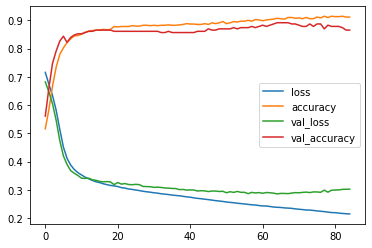

In [ ]:
pd.DataFrame(ann.history.history).plot()

In [ ]:
cm = confusion_matrix(Y_test, y_pred)
print("confusion matrix : \n", cm)
acc = accuracy_score(Y_test, y_pred)
print("\naccuracy score = ", acc)
ann_evaluate = ann.evaluate(X_test, Y_test)
print("\nann evaluate = ", ann_evaluate)
class_report = classification_report(Y_test, y_pred)
print("\nclassification report : \n", class_report)

confusion matrix : 
 [[ 86  12]
 [ 19 113]]

accuracy score =  0.8652173913043478
8/8 [==============================] - 0s 2ms/step - loss: 0.3022 - accuracy: 0.8652

ann evaluate =  [0.3022153377532959, 0.865217387676239]

classification report : 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



## Compare between actual and predicted

In [ ]:
# print(np.concatenate((y_pred.reshape(len(y_pred),1), Y_test.reshape(len(Y_test),1)),1)[0:10])
df = pd.DataFrame({'Actual': Y_test.flatten(), 'predicted': y_pred.flatten()})
df.head()

## Try to Predict

In [ ]:
print(ann.predict(sc.transform([[619, 1, 1, 42, 2, 0.0, 1, 0, 0, 101348.88]])) > 0.5)

# Extra Notes
---



In [ ]:
# Custom 
# https://keras.io/guides/writing_your_own_callbacks/

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))
  


class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    def on_test_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["mean_absolute_error"]
            )
        )

In [ ]:
# Example
"""
compile, fit, predict : https://keras.io/api/models/model_training_apis/

activation function : https://keras.io/api/layers/activations/

"""

# a dense class example
tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)




model.add(Dense(12, input_dim=8, activation='relu'))


Model.compile(
    optimizer="rmsprop",
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    **kwargs
)
or
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])



model.fit(
    x_train=None, y_train=None,
    batch_size=None,
    epochs=1,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

res = model.evaluate(
    x_test, y_test,
    batch_size=None,
    verbose=1,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
    **kwargs
)

Model.predict(
    x_test,
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

In [ ]:
# The inputs are 28x28 RGB images with `channels_last` and the batch size is 4
input_shape = (4, 28, 28, 3)

# conv2D
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

# MaxPooling2D 
tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid", data_format=None, **kwargs
)



In [ ]:
model = Sequential()
model.add(Dense(60, input_shape = (33,), activation = "relu"))
model.add(Dense(15, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation = "softmax"))
model.compile(Adam(lr = 0.01), "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate(Y_test, y_pred)
print('Accuracy: %.2f' % (accuracy*100))

1. https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5